# Приоритизация и A/B тест гипотез для увеличения выручки

Вместе с отделом маркетинга был подготовлен список гипотез для увеличения выручки.
Приоритизируем гипотезы, запустим A/B-тест и проанализируем результаты.

**Цель исследования:** отобрать и предложенные проверить гипотезы по увеличению выручки магазина

**Содержание**
    
    
1. [Изучение данных из файлов](#open)
    
    
2. [Часть 1. Приоритизация гипотез.](#preproc)
     
    
3. [Часть 2. Анализ A/B-теста](#pred)


4. [Общий вывод](#summary)

<a id="open"></a>
## Изучение данных из файла

**Данные для первой части:**

**Таблица hypothesis** (информация о гипотезах):

Hypothesis — краткое описание гипотезы;<br>
Reach — охват пользователей по 10-балльной шкале;<br>
Impact — влияние на пользователей по 10-балльной шкале;<br>
Confidence — уверенность в гипотезе по 10-балльной шкале;<br>
Efforts — затраты ресурсов на проверку гипотезы по 10-балльной шкале. Чем больше значение Efforts, тем дороже проверка гипотезы.


**Данные для второй части:**

**Таблица orders** (информация о заказах):

transactionId — идентификатор заказа;<br>
visitorId — идентификатор пользователя, совершившего заказ;<br>
date — дата, когда был совершён заказ;<br>
revenue — выручка заказа;<br>
group — группа A/B-теста, в которую попал заказ.


**Таблица visitors** (информация о трафике):

date — дата;<br>
group — группа A/B-теста;<br>
visitors — количество пользователей в указанную дату в указанной группе A/B-теста

In [1]:
# Импортируем библиотеки

import pandas as pd
import seaborn as sb
import datetime as dt
import matplotlib.pyplot as plt
import numpy as np
from math import factorial
from scipy import stats as st

pd.set_option('display.max_columns', None)
pd.set_option('display.max_colwidth', 500)
pd.set_option('display.float_format', '{:,.2f}'.format)

from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()

In [2]:
# Изучаем таблицу гипотез

hypothesis = pd.read_csv('/datasets/hypothesis.csv', sep = ',' )
display(hypothesis.head(10))
hypothesis.tail(10)
hypothesis.sample(5)
hypothesis.info()


,Hypothesis,Reach,Impact,Confidence,Efforts
0,"Добавить два новых канала привлечения трафика, что позволит привлекать на 30% больше пользователей",3,10,8,6
1,"Запустить собственную службу доставки, что сократит срок доставки заказов",2,5,4,10
2,"Добавить блоки рекомендаций товаров на сайт интернет магазина, чтобы повысить конверсию и средний чек заказа",8,3,7,3
3,"Изменить структура категорий, что увеличит конверсию, т.к. пользователи быстрее найдут нужный товар",8,3,3,8
4,"Изменить цвет фона главной страницы, чтобы увеличить вовлеченность пользователей",3,1,1,1
5,"Добавить страницу отзывов клиентов о магазине, что позволит увеличить количество заказов",3,2,2,3
6,"Показать на главной странице баннеры с актуальными акциями и распродажами, чтобы увеличить конверсию",5,3,8,3
7,"Добавить форму подписки на все основные страницы, чтобы собрать базу клиентов для email-рассылок",10,7,8,5
8,"Запустить акцию, дающую скидку на товар в день рождения",1,9,9,5


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9 entries, 0 to 8
Data columns (total 5 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   Hypothesis  9 non-null      object
 1   Reach       9 non-null      int64 
 2   Impact      9 non-null      int64 
 3   Confidence  9 non-null      int64 
 4   Efforts     9 non-null      int64 
dtypes: int64(4), object(1)
memory usage: 488.0+ bytes


In [3]:
# Изучаем таблицу заказов по результатам A/B теста

orders = pd.read_csv('/datasets/orders.csv', sep = ',' )
display(orders.head(10))
orders.tail(10)
orders.sample(5)

# Приведем дату к нужному для исследования виду
orders['date'] = orders['date'].map(
    lambda x: dt.datetime.strptime(x, '%Y-%m-%d')
)

orders.info()
orders.describe().T

,transactionId,visitorId,date,revenue,group
0,3667963787,3312258926,2019-08-15,1650,B
1,2804400009,3642806036,2019-08-15,730,B
2,2961555356,4069496402,2019-08-15,400,A
3,3797467345,1196621759,2019-08-15,9759,B
4,2282983706,2322279887,2019-08-15,2308,B
5,182168103,935554773,2019-08-15,2210,B
6,398296753,2900797465,2019-08-15,1860,B
7,2626614568,78758296,2019-08-15,1044,A
8,1576988021,295230930,2019-08-15,13710,A
9,1506739906,1882260405,2019-08-15,1855,B


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1197 entries, 0 to 1196
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype         
---  ------         --------------  -----         
 0   transactionId  1197 non-null   int64         
 1   visitorId      1197 non-null   int64         
 2   date           1197 non-null   datetime64[ns]
 3   revenue        1197 non-null   int64         
 4   group          1197 non-null   object        
dtypes: datetime64[ns](1), int64(3), object(1)
memory usage: 46.9+ KB


,count,mean,std,min,25%,50%,75%,max
transactionId,"1,197.00","2,155,621,385.53","1,229,084,904.76","1,062,393.00","1,166,775,572.00","2,145,193,898.00","3,237,740,112.00","4,293,855,558.00"
visitorId,"1,197.00","2,165,960,143.10","1,236,014,192.15","5,114,589.00","1,111,826,046.00","2,217,984,702.00","3,177,606,451.00","4,283,872,382.00"
revenue,"1,197.00","8,348.01","39,191.13",50.00,"1,220.00","2,978.00","8,290.00","1,294,500.00"


In [4]:
# Изучаем таблицу трафика по результатам A/B теста

visitors = pd.read_csv('/datasets/visitors.csv', sep = ',' )
display(visitors.head(10))
visitors.tail(10)
visitors.sample(5)

# Приведем дату к нужному для исследования виду
visitors['date'] = visitors['date'].map(
    lambda x: dt.datetime.strptime(x, '%Y-%m-%d')
)

visitors.info()
visitors.describe().T

,date,group,visitors
0,2019-08-01,A,719
1,2019-08-02,A,619
2,2019-08-03,A,507
3,2019-08-04,A,717
4,2019-08-05,A,756
5,2019-08-06,A,667
6,2019-08-07,A,644
7,2019-08-08,A,610
8,2019-08-09,A,617
9,2019-08-10,A,406


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 62 entries, 0 to 61
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype         
---  ------    --------------  -----         
 0   date      62 non-null     datetime64[ns]
 1   group     62 non-null     object        
 2   visitors  62 non-null     int64         
dtypes: datetime64[ns](1), int64(1), object(1)
memory usage: 1.6+ KB


,count,mean,std,min,25%,50%,75%,max
visitors,62.00,607.29,114.40,361.00,534.00,624.50,710.50,770.00


In [5]:
# Проверим, есть посетители попавшие в обе группы.

user_group = orders.groupby('visitorId', as_index=False).agg({'group': pd.Series.nunique})

# user_group[user_group['group']>1]['visitorId'].count()
# Таких 58

users_bad = user_group[user_group['group']>1]['visitorId']

# Удалим таких юзеров из выборки, так как они мешают исследованию
orders = orders[~orders['visitorId'].isin(users_bad)] 

display(orders)

,transactionId,visitorId,date,revenue,group
0,3667963787,3312258926,2019-08-15,1650,B
1,2804400009,3642806036,2019-08-15,730,B
3,3797467345,1196621759,2019-08-15,9759,B
4,2282983706,2322279887,2019-08-15,2308,B
5,182168103,935554773,2019-08-15,2210,B
...,...,...,...,...,...
1191,3592955527,608641596,2019-08-14,16490,B
1192,2662137336,3733762160,2019-08-14,6490,B
1193,2203539145,370388673,2019-08-14,3190,A
1194,1807773912,573423106,2019-08-14,10550,A


### Вывод

Данные открыты и изучены, из выборки были удалены посетители, попавшие сразу в две группы. Можно приступать к исследованию.

<a id="preproc"></a>
## Часть 1. Приоритизация гипотез

Применим фреймворк ICE для приоритизации гипотез. Отсортируем их по убыванию приоритета.

In [6]:
hypothesis['ICE'] = (hypothesis['Impact'] * hypothesis['Confidence'])/hypothesis['Efforts']

display(hypothesis[['Hypothesis','ICE']].sort_values(by='ICE', ascending=False))

,Hypothesis,ICE
8,"Запустить акцию, дающую скидку на товар в день рождения",16.20
0,"Добавить два новых канала привлечения трафика, что позволит привлекать на 30% больше пользователей",13.33
7,"Добавить форму подписки на все основные страницы, чтобы собрать базу клиентов для email-рассылок",11.20
6,"Показать на главной странице баннеры с актуальными акциями и распродажами, чтобы увеличить конверсию",8.00
2,"Добавить блоки рекомендаций товаров на сайт интернет магазина, чтобы повысить конверсию и средний чек заказа",7.00
1,"Запустить собственную службу доставки, что сократит срок доставки заказов",2.00
5,"Добавить страницу отзывов клиентов о магазине, что позволит увеличить количество заказов",1.33
3,"Изменить структура категорий, что увеличит конверсию, т.к. пользователи быстрее найдут нужный товар",1.12
4,"Изменить цвет фона главной страницы, чтобы увеличить вовлеченность пользователей",1.00


Применим фреймворк RICE для приоритизации гипотез. Отсортируем их по убыванию приоритета.

In [7]:
hypothesis['RICE'] = (hypothesis['Reach'] * hypothesis['Impact'] * hypothesis['Confidence'])/hypothesis['Efforts']

display(hypothesis[['Hypothesis','RICE']].sort_values(by='RICE', ascending=False))

,Hypothesis,RICE
7,"Добавить форму подписки на все основные страницы, чтобы собрать базу клиентов для email-рассылок",112.00
2,"Добавить блоки рекомендаций товаров на сайт интернет магазина, чтобы повысить конверсию и средний чек заказа",56.00
0,"Добавить два новых канала привлечения трафика, что позволит привлекать на 30% больше пользователей",40.00
6,"Показать на главной странице баннеры с актуальными акциями и распродажами, чтобы увеличить конверсию",40.00
8,"Запустить акцию, дающую скидку на товар в день рождения",16.20
3,"Изменить структура категорий, что увеличит конверсию, т.к. пользователи быстрее найдут нужный товар",9.00
1,"Запустить собственную службу доставки, что сократит срок доставки заказов",4.00
5,"Добавить страницу отзывов клиентов о магазине, что позволит увеличить количество заказов",4.00
4,"Изменить цвет фона главной страницы, чтобы увеличить вовлеченность пользователей",3.00


In [8]:
priority = hypothesis[['Hypothesis','RICE']].merge(hypothesis[['Hypothesis','ICE']], on = 'Hypothesis' )
priority['rang'] = priority['RICE'].rank(ascending=False, method = 'first')
display(priority.sort_values(by=['RICE', 'ICE'], ascending=False).style.apply(lambda x: ['background: lightgreen' if x.rang < 6 else '' for i in x],  axis=1))

,Hypothesis,RICE,ICE,rang
7,"Добавить форму подписки на все основные страницы, чтобы собрать базу клиентов для email-рассылок",112.000000,11.200000,1.000000
2,"Добавить блоки рекомендаций товаров на сайт интернет магазина, чтобы повысить конверсию и средний чек заказа",56.000000,7.000000,2.000000
0,"Добавить два новых канала привлечения трафика, что позволит привлекать на 30% больше пользователей",40.000000,13.333333,3.000000
6,"Показать на главной странице баннеры с актуальными акциями и распродажами, чтобы увеличить конверсию",40.000000,8.000000,4.000000
8,"Запустить акцию, дающую скидку на товар в день рождения",16.200000,16.200000,5.000000
3,"Изменить структура категорий, что увеличит конверсию, т.к. пользователи быстрее найдут нужный товар",9.000000,1.125000,6.000000
1,"Запустить собственную службу доставки, что сократит срок доставки заказов",4.000000,2.000000,7.000000
5,"Добавить страницу отзывов клиентов о магазине, что позволит увеличить количество заказов",4.000000,1.333333,8.000000
4,"Изменить цвет фона главной страницы, чтобы увеличить вовлеченность пользователей",3.000000,1.000000,9.000000


### Вывод
При применении фреймворка ICE самыми приоритетными (топ 3) оказались гипотезы с индексами 8, 0 и 7. Фреймворк RICE показал иную приоритетность: 7, 2, 0 и 6. Приоритет изменился, так как фреймворк RICE учитывает параметр "Reach" - скольких пользователей затронет изменение, которое мы хотите внести. У гипотезы 8 (Запустить акцию, дающую скидку на товар в день рождения) Reach оценен всего в 1 балл, поскольку, к сожалению, день рождения только раз в году.
Зато добавились в приоритет гипотезы 2 и 6 с достаточно высоким Reach. Итоговый список приоритетов может выглядеть следующим образом:

* Добавить форму подписки на все основные страницы, чтобы собрать базу клиентов для email-рассылок
* Добавить блоки рекомендаций товаров на сайт интернет магазина, чтобы повысить конверсию и средний чек заказа
* Добавить два новых канала привлечения трафика, что позволит привлекать на 30% больше пользователей
* Показать на главной странице баннеры с актуальными акциями и распродажами, чтобы увеличить конверсию
* Запустить акцию, дающую скидку на товар в день рождения

<a id="pred"></a>
## Часть 2. Анализ A/B-теста

1. Построим график кумулятивной выручки по группам.

In [9]:
# создаем массив уникальных пар значений дат и групп теста
datesGroups = orders[['date','group']].drop_duplicates() 

# получаем агрегированные кумулятивные по дням данные о заказах 
ordersAggregated = datesGroups.apply(lambda x: orders[np.logical_and(orders['date'] <= x['date'], orders['group'] == x['group'])].agg({'date' : 'max', 'group' : 'max', 'transactionId' : 'nunique', 'visitorId' : 'nunique', 'revenue' : 'sum'}), axis=1).sort_values(by=['date','group'])

# # получаем агрегированные кумулятивные по дням данные о посетителях интернет-магазина 
visitorsAggregated = datesGroups.apply(lambda x: visitors[np.logical_and(visitors['date'] <= x['date'], visitors['group'] == x['group'])].agg({'date' : 'max', 'group' : 'max', 'visitors' : 'sum'}), axis=1).sort_values(by=['date','group'])

# объединяем кумулятивные данные в одной таблице и присваиваем ее столбцам понятные названия
cumulativeData = ordersAggregated.merge(visitorsAggregated, left_on=['date', 'group'], right_on=['date', 'group'])
cumulativeData.columns = ['date', 'group', 'orders', 'buyers', 'revenue', 'visitors']

print(cumulativeData.tail(5)) 


         date group  orders  buyers  revenue  visitors
57 2019-08-29     B     510     490  4746610     17708
58 2019-08-30     A     460     437  3311413     18037
59 2019-08-30     B     531     511  4955833     18198
60 2019-08-31     A     468     445  3364656     18736
61 2019-08-31     B     548     528  5068972     18916


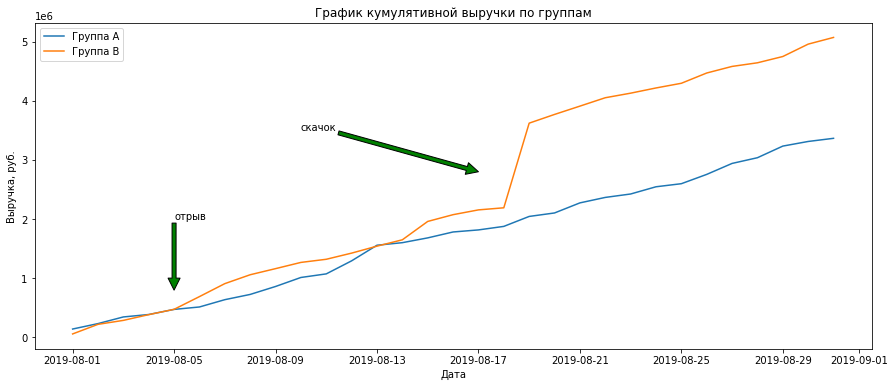

In [10]:
# датафрейм с кумулятивным количеством заказов и кумулятивной выручкой по дням в группе А
cumulativeRevenueA = cumulativeData[cumulativeData['group']=='A'][['date','revenue', 'orders']]

# датафрейм с кумулятивным количеством заказов и кумулятивной выручкой по дням в группе B
cumulativeRevenueB = cumulativeData[cumulativeData['group']=='B'][['date','revenue', 'orders']]

# Строим график выручки группы А
plt.figure(figsize=(15,6))
plt.plot(cumulativeRevenueA['date'], cumulativeRevenueA['revenue'], label='Группа A')

# Строим график выручки группы B
plt.plot(cumulativeRevenueB['date'], cumulativeRevenueB['revenue'], label='Группа B')
plt.title("График кумулятивной выручки по группам")
plt.legend() 
plt.xlabel('Дата')
plt.ylabel('Выручка, руб.')

plt.annotate('скачок', xy=('2019-08-17', 2800000), xytext=('2019-08-10', 3500000),
            arrowprops=dict(facecolor='g'))
plt.annotate('отрыв', xy=('2019-08-05', 800000), xytext=('2019-08-05', 2000000),
            arrowprops=dict(facecolor='g')) 

plt.show()

Выручка почти равномерно увеличивается до 17-18 августа 2019, затем график по группе B резко опережает группу A. Это может сигнализировать о выбросах по числу или стоимости заказов.

2. Построим график кумулятивного среднего чека по группам.

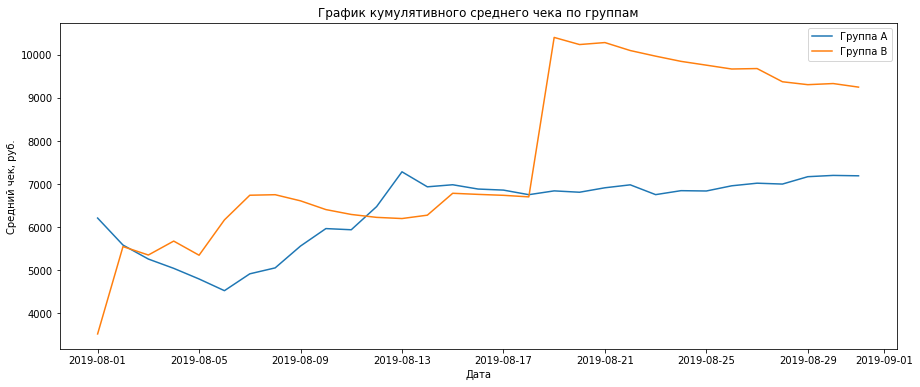

In [11]:
plt.figure(figsize=(15,6))
plt.plot(cumulativeRevenueA['date'], cumulativeRevenueA['revenue']/cumulativeRevenueA['orders'], label='Группа A')
plt.plot(cumulativeRevenueB['date'], cumulativeRevenueB['revenue']/cumulativeRevenueB['orders'], label='Группа B')
plt.title("График кумулятивного среднего чека по группам")
plt.legend() 
plt.xlabel('Дата')
plt.ylabel('Средний чек, руб.')
plt.show()

Средний чек тоже испытывает всплески, особенно для группы B в середине тестируемого периода., это может быть связано с одним или несколькими крупными заказами. В то же время график группы A начал стабилизироваться, но это не точно.

3. Построим график относительного изменения кумулятивного среднего чека группы B к группе A.

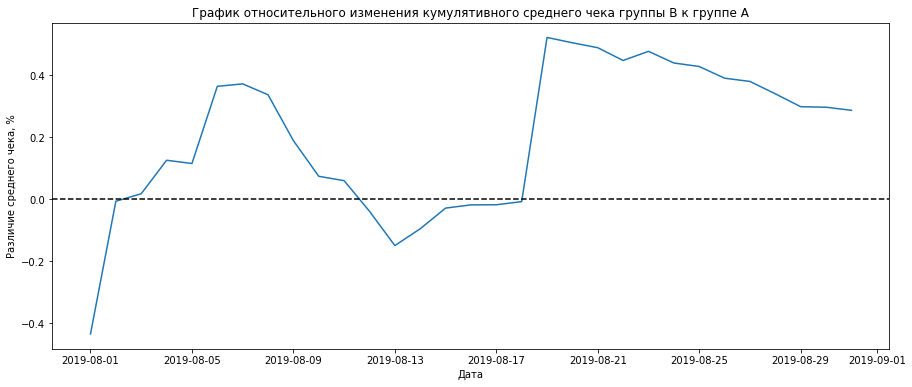

In [12]:
# собираем данные в одном датафрейме
mergedCumulativeRevenue = cumulativeRevenueA.merge(cumulativeRevenueB, left_on='date', right_on='date', how='left', suffixes=['A', 'B'])

# cтроим отношение средних чеков
plt.figure(figsize=(15,6))
plt.plot(mergedCumulativeRevenue['date'], (mergedCumulativeRevenue['revenueB']/mergedCumulativeRevenue['ordersB'])/(mergedCumulativeRevenue['revenueA']/mergedCumulativeRevenue['ordersA'])-1)

# добавляем ось X
plt.axhline(y=0, color='black', linestyle='--') 
plt.title("График относительного изменения кумулятивного среднего чека группы B к группе A")
plt.xlabel('Дата')
plt.ylabel('Различие среднего чека, %')
plt.show()

График резко меняется в нескольких точках (особенно рост на 6 пунктов в середине периода), скорее всего это связано с выбросами в сырых данных.

4. Построим график кумулятивной конверсии по группам.

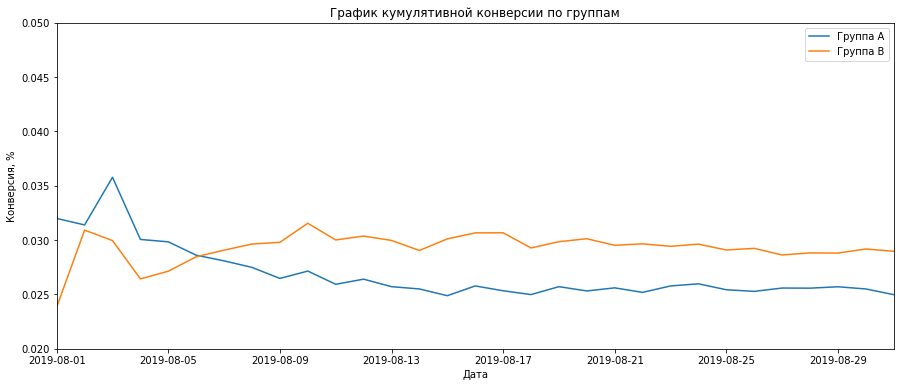

In [13]:
# считаем кумулятивную конверсию
cumulativeData['conversion'] = cumulativeData['orders']/cumulativeData['visitors']

# отделяем данные по группе A
cumulativeDataA = cumulativeData[cumulativeData['group']=='A']

# отделяем данные по группе B
cumulativeDataB = cumulativeData[cumulativeData['group']=='B']

# строим графики
plt.figure(figsize=(15,6))
plt.plot(cumulativeDataA['date'], cumulativeDataA['conversion'], label='Группа A')
plt.plot(cumulativeDataB['date'], cumulativeDataB['conversion'], label='Группа B')
plt.legend()

# задаем масштаб осей
plt.axis(["2019-08-01", '2019-08-31', 0.02, 0.05]) 
plt.title("График кумулятивной конверсии по группам")
plt.xlabel('Дата')
plt.ylabel('Конверсия, %')
plt.show()

Графики шли рядом в начале периода, но затем конверсия по группе B вышла вперед и стабильно опережала группу A до конца тестирования. Абсолютные значения достаточно ровные с разбросом не более 1%.

5. Построим график относительного изменения кумулятивной конверсии группы B к группе A.

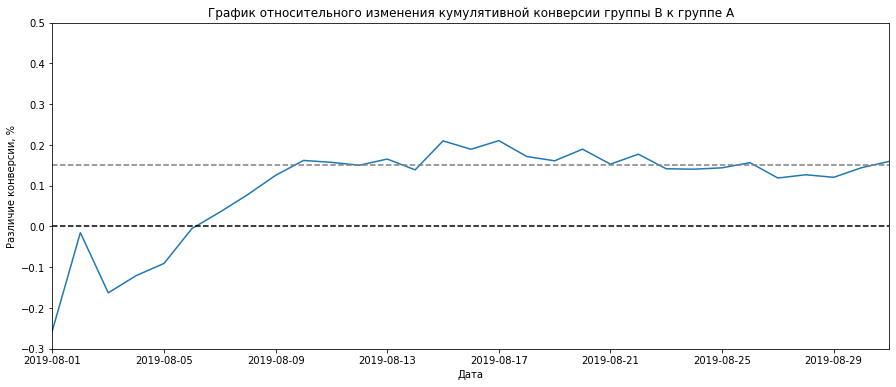

In [14]:
mergedCumulativeConversions = cumulativeDataA[['date','conversion']].merge(cumulativeDataB[['date','conversion']], left_on='date', right_on='date', how='left', suffixes=['A', 'B'])

plt.figure(figsize=(15,6))
plt.plot(mergedCumulativeConversions['date'], mergedCumulativeConversions['conversionB']/mergedCumulativeConversions['conversionA']-1, label="Относительный прирост конверсии группы B относительно группы A")

plt.axhline(y=0, color='black', linestyle='--')
plt.axhline(y=0.15, color='grey', linestyle='--')
plt.axis(["2019-08-01", '2019-08-31', -0.3, 0.5]) 
plt.title("График относительного изменения кумулятивной конверсии группы B к группе A")
plt.xlabel('Дата')
plt.ylabel('Различие конверсии, %')
plt.show()

Почти с начала периода группа B лидирует по конверсии и фиксируется около 15% прироста относительно конверсии группы A.


Проанализируем аномалии для более точных выводов.

6. Построим точечный график количества заказов по пользователям.

,visitorId,orders
908,3967698036,3
55,249864742,3
478,2108163459,3
687,2988190573,3
890,3908431265,3
138,611059232,3
632,2742574263,3
157,678354126,2
323,1404560065,2
452,1985475298,2


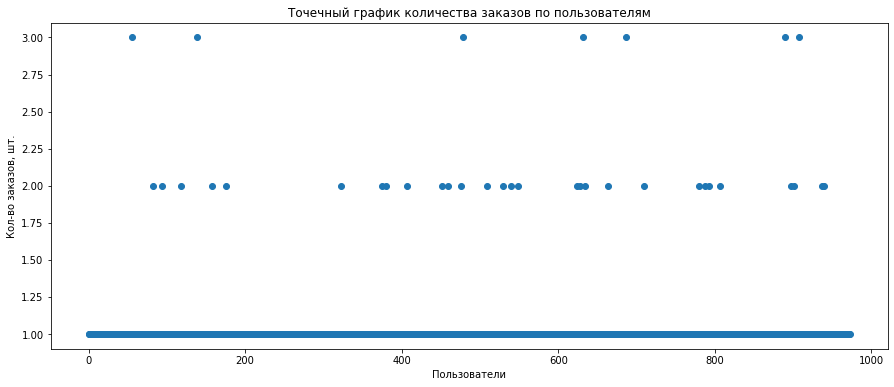

In [15]:
ordersByUsers = (
    orders.groupby('visitorId', as_index=False)
    .agg({'transactionId': pd.Series.nunique})
)

ordersByUsers.columns = ['visitorId', 'orders']

display(ordersByUsers.sort_values(by='orders', ascending=False).head(10)) 

x_values = pd.Series(range(0, len(ordersByUsers)))

plt.figure(figsize=(15,6))
plt.scatter(x_values, ordersByUsers['orders']) 
plt.title("Точечный график количества заказов по пользователям")
plt.xlabel('Пользователи')
plt.ylabel('Кол-во заказов, шт.')
plt.show()

Абсолютное большинство делает 1 заказ, до 3 заказов доходят редко. Посмотрим на выборочные перцентили.

7. Посчитаем 95-й и 99-й перцентили количества заказов на пользователя. Выберем границу для определения аномальных пользователей.

In [16]:
print(np.percentile(ordersByUsers['orders'], [95, 99])) 

[1. 2.]


Не более 5% посетителей сайта совершали больше 1 заказа и не более 1% посетителей - больше 2х заказов. Разумно выбрать 2 заказа на одного пользователя за верхнюю границу числа заказов, и отсеять аномальных пользователей по ней.

8. Построем точечный график стоимостей заказов.

,transactionId,visitorId,date,revenue,group
425,590470918,1920142716,2019-08-19,1294500,B
1196,3936777065,2108080724,2019-08-15,202740,B
1136,666610489,1307669133,2019-08-13,92550,A
744,3668308183,888512513,2019-08-27,86620,B
743,3603576309,4133034833,2019-08-09,67990,A
1103,1348774318,1164614297,2019-08-12,66350,A
1099,316924019,148427295,2019-08-12,65710,A
949,1347999392,887908475,2019-08-21,60450,A
940,2420050534,4003628586,2019-08-08,58550,B
131,3163614039,2254586615,2019-08-22,53904,A


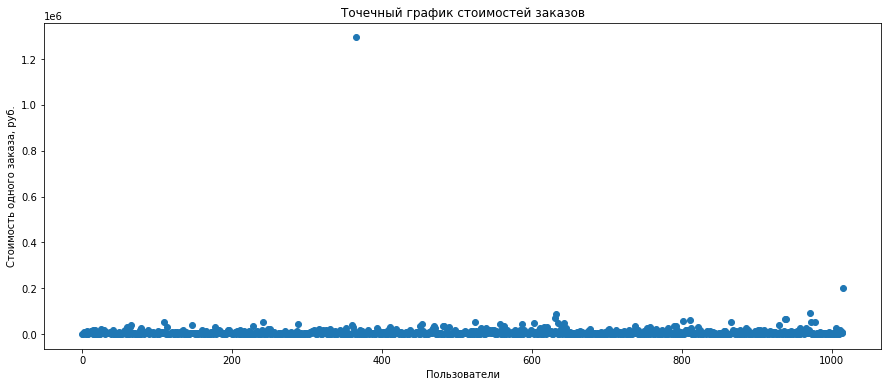

In [17]:
display(orders.sort_values(by='revenue', ascending=False).head(10))

x_values = pd.Series(range(0, len(orders['revenue'])))

plt.figure(figsize=(15,6))
plt.scatter(x_values, orders['revenue']) 
plt.title("Точечный график стоимостей заказов")
plt.xlabel('Пользователи')
plt.ylabel('Стоимость одного заказа, руб.')
plt.show()

Заказов стоимостью более 100 000 практически нет. Видны выбросы на 200 000 и на 1,3млн. Посмотрим на перцентили.

9. Посчитаем 95-й и 99-й перцентили стоимости заказов. Выберем границу для определения аномальных заказов.

In [18]:
print(np.percentile(orders['revenue'], [95, 99])) 

[26785. 53904.]


Не более чем у 5% заказов чек дороже 26785 и не более 1% заказов - дороже 53904. Разумно выбрать верхнюю границу среднего чека на 50 000 и отсеять аномальные чеки по ней.

10. Посчитаем статистическую значимость различий в конверсии между группами по «сырым» данным. 

Сформулируем 0-гипотезу: Конверсия в заказ пользователей группы «A» и группы «B» по «сырым» данным равны;

Сформулируем N-гипотезу: Конверсия в заказ пользователей группы «A» и группы «B» по «сырым» данным различаются.

In [19]:
# Подготовим данные

visitorsADaily = visitors[visitors['group'] == 'A'][['date', 'visitors']]
visitorsADaily.columns = ['date', 'visitorsPerDateA']

visitorsACummulative = visitorsADaily.apply(
    lambda x: visitorsADaily[visitorsADaily['date'] <= x['date']].agg(
        {'date': 'max', 'visitorsPerDateA': 'sum'}
    ),
    axis=1,
)
visitorsACummulative.columns = ['date', 'visitorsCummulativeA']

visitorsBDaily = visitors[visitors['group'] == 'B'][['date', 'visitors']]
visitorsBDaily.columns = ['date', 'visitorsPerDateB']

visitorsBCummulative = visitorsBDaily.apply(
    lambda x: visitorsBDaily[visitorsBDaily['date'] <= x['date']].agg(
        {'date': 'max', 'visitorsPerDateB': 'sum'}
    ),
    axis=1,
)
visitorsBCummulative.columns = ['date', 'visitorsCummulativeB']

ordersADaily = (
    orders[orders['group'] == 'A'][['date', 'transactionId', 'visitorId', 'revenue']]
    .groupby('date', as_index=False)
    .agg({'transactionId': pd.Series.nunique, 'revenue': 'sum'})
)
ordersADaily.columns = ['date', 'ordersPerDateA', 'revenuePerDateA']

ordersACummulative = ordersADaily.apply(
    lambda x: ordersADaily[ordersADaily['date'] <= x['date']].agg(
        {'date': 'max', 'ordersPerDateA': 'sum', 'revenuePerDateA': 'sum'}
    ),
    axis=1,
).sort_values(by=['date'])
ordersACummulative.columns = [
    'date',
    'ordersCummulativeA',
    'revenueCummulativeA',
]

ordersBDaily = (
    orders[orders['group'] == 'B'][['date', 'transactionId', 'visitorId', 'revenue']]
    .groupby('date', as_index=False)
    .agg({'transactionId': pd.Series.nunique, 'revenue': 'sum'})
)
ordersBDaily.columns = ['date', 'ordersPerDateB', 'revenuePerDateB']

ordersBCummulative = ordersBDaily.apply(
    lambda x: ordersBDaily[ordersBDaily['date'] <= x['date']].agg(
        {'date': 'max', 'ordersPerDateB': 'sum', 'revenuePerDateB': 'sum'}
    ),
    axis=1,
).sort_values(by=['date'])
ordersBCummulative.columns = [
    'date',
    'ordersCummulativeB',
    'revenueCummulativeB',
]

data = (
    ordersADaily.merge(
        ordersBDaily, left_on='date', right_on='date', how='left'
    )
    .merge(ordersACummulative, left_on='date', right_on='date', how='left')
    .merge(ordersBCummulative, left_on='date', right_on='date', how='left')
    .merge(visitorsADaily, left_on='date', right_on='date', how='left')
    .merge(visitorsBDaily, left_on='date', right_on='date', how='left')
    .merge(visitorsACummulative, left_on='date', right_on='date', how='left')
    .merge(visitorsBCummulative, left_on='date', right_on='date', how='left')
)

display(data.head(5))


ordersByUsersA = (
    orders[orders['group'] == 'A']
    .groupby('visitorId', as_index=False)
    .agg({'transactionId': pd.Series.nunique})
)
ordersByUsersA.columns = ['visitorId', 'orders']

ordersByUsersB = (
    orders[orders['group'] == 'B']
    .groupby('visitorId', as_index=False)
    .agg({'transactionId': pd.Series.nunique})
)
ordersByUsersB.columns = ['visitorId', 'orders'] 


sampleA = pd.concat([ordersByUsersA['orders'],pd.Series(0, index=np.arange(data['visitorsPerDateA'].sum() - len(ordersByUsersA['orders'])), name='orders')],axis=0)

sampleB = pd.concat([ordersByUsersB['orders'],pd.Series(0, index=np.arange(data['visitorsPerDateB'].sum() - len(ordersByUsersB['orders'])), name='orders')],axis=0) 


ordersByUsersA = (
    orders[orders['group'] == 'A']
    .groupby('visitorId', as_index=False)
    .agg({'transactionId': pd.Series.nunique})
)
ordersByUsersA.columns = ['visitorId', 'orders']

ordersByUsersB = (
    orders[orders['group'] == 'B']
    .groupby('visitorId', as_index=False)
    .agg({'transactionId': pd.Series.nunique})
)
ordersByUsersB.columns = ['visitorId', 'orders']

sampleA = pd.concat(
    [
        ordersByUsersA['orders'],
        pd.Series(
            0,
            index=np.arange(
                data['visitorsPerDateA'].sum() - len(ordersByUsersA['orders'])
            ),
            name='orders',
        ),
    ],
    axis=0,
)

sampleB = pd.concat(
    [
        ordersByUsersB['orders'],
        pd.Series(
            0,
            index=np.arange(
                data['visitorsPerDateB'].sum() - len(ordersByUsersB['orders'])
            ),
            name='orders',
        ),
    ],
    axis=0,
)



print('p-value =',"{0:.3f}".format(st.mannwhitneyu(sampleA, sampleB)[1]))

# print("{0:.3f}".format(sampleB.mean() / sampleA.mean() - 1))

print('Относительный прирост конверсии группы B к группе A =',"{0:.3f}".format((data['ordersPerDateB'].sum()/data['visitorsPerDateB'].sum())/(data['ordersPerDateA'].sum()/data['visitorsPerDateA'].sum())-1)) 


# Названия столбцов данных:
# date — дата;
# ordersPerDateA — количество заказов в выбранную дату в группе A;
# revenuePerDateA — суммарная выручка в выбранную дату в группе A;
# ordersPerDateB — количество заказов в выбранную дату в группе B;
# revenuePerDateB — суммарная выручка в выбранную дату в группе B;
# ordersCummulativeA — суммарное число заказов до выбранной даты включительно в группе A;
# revenueCummulativeA — суммарная выручка до выбранной даты включительно в группе A;
# ordersCummulativeB — суммарное количество заказов до выбранной даты включительно в группе B;
# revenueCummulativeB — суммарная выручка до выбранной даты включительно в группе B;
# visitorsPerDateA — количество пользователей в выбранную дату в группе A;
# visitorsPerDateB — количество пользователей в выбранную дату в группе B;
# visitorsCummulativeA — количество пользователей до выбранной даты включительно в группе A;
# visitorsCummulativeB — количество пользователей до выбранной даты включительно в группе B.


,date,ordersPerDateA,revenuePerDateA,ordersPerDateB,revenuePerDateB,ordersCummulativeA,revenueCummulativeA,ordersCummulativeB,revenueCummulativeB,visitorsPerDateA,visitorsPerDateB,visitorsCummulativeA,visitorsCummulativeB
0,2019-08-01,23,142779,17,59758,23,142779,17,59758,719,713,719,713
1,2019-08-02,19,91602,23,162043,42,234381,40,221801,619,581,1338,1294
2,2019-08-03,24,112473,14,67049,66,346854,54,288850,507,509,1845,1803
3,2019-08-04,11,41176,14,96890,77,388030,68,385740,717,770,2562,2573
4,2019-08-05,22,86383,21,89908,99,474413,89,475648,756,707,3318,3280


p-value = 0.011
Относительный прирост конверсии группы B к группе A = 0.160


P-value заметно меньше 0.05, поэтому отвергаем нулевую гиппотезу - статистически значимые различия между группами по конверсии обнаружены.
Относительный прирост конверсии в группе B равен 16%.

11. Посчитаем статистическую значимость различий в среднем чеке заказа между группами по «сырым» данным.

Сформулируем 0-гипотезу: Средний чек заказа пользователей группы «A» и группы «B» по «сырым» данным равны;

Сформулируем N-гипотезу: Средний чек заказа пользователей группы «A» и группы «B» по «сырым» данным различаются.

In [20]:
print('p-value =','{0:.3f}'.format(st.mannwhitneyu(orders[orders['group']=='A']['revenue'], orders[orders['group']=='B']['revenue'])[1]))
print('Относительное различие среднего чека группы B к группе A =','{0:.3f}'.format(orders[orders['group']=='B']['revenue'].mean()/orders[orders['group']=='A']['revenue'].mean()-1)) 

p-value = 0.829
Относительное различие среднего чека группы B к группе A = 0.287


P-value больше 0.05, поэтому мы не отвергаем нулевую гиппотезу - статистически значимые различия между группами по среднему чеку отсутствуют.
Однако относительный прирост среднего чека в группе B значительный: 28.7%.

12. Посчитаем статистическую значимость различий в конверсии между группами по «очищенным» данным.

Сформулируем 0-гипотезу: Конверсия в заказ пользователей группы «A» и группы «B» по «очищенным» данным равны;

Сформулируем N-гипотезу: Конверсия в заказ пользователей группы «A» и группы «B» по «очищенным» данным различаются.

В соответствии с нашими решениями, отсеем аномальных посетителей по границе более 2 заказов и заказы дороже 50 000.

In [21]:
usersWithManyOrders = pd.concat(
    [
        ordersByUsersA[ordersByUsersA['orders'] > 2]['visitorId'],
        ordersByUsersB[ordersByUsersB['orders'] > 2]['visitorId'],
    ],
    axis=0,
)
usersWithExpensiveOrders = orders[orders['revenue'] > 50000]['visitorId']
abnormalUsers = (
    pd.concat([usersWithManyOrders, usersWithExpensiveOrders], axis=0)
    .drop_duplicates()
    .sort_values()
)
print(abnormalUsers.head(5))
print(abnormalUsers.shape) 

1099    148427295
33      249864742
58      611059232
1137    759473111
949     887908475
Name: visitorId, dtype: int64
(22,)


Всего 22 аномальных посетителей. Посчитаем статистическую значимость различия конверсии после удаления выбросов.

In [22]:

sampleAFiltered = pd.concat(
    [
        ordersByUsersA[
            np.logical_not(ordersByUsersA['visitorId'].isin(abnormalUsers))
        ]['orders'],
        pd.Series(
            0,
            index=np.arange(
                data['visitorsPerDateA'].sum() - len(ordersByUsersA['orders'])
            ),
            name='orders',
        ),
    ],
    axis=0,
)

sampleBFiltered = pd.concat(
    [
        ordersByUsersB[
            np.logical_not(ordersByUsersB['visitorId'].isin(abnormalUsers))
        ]['orders'],
        pd.Series(
            0,
            index=np.arange(
                data['visitorsPerDateB'].sum() - len(ordersByUsersB['orders'])
            ),
            name='orders',
        ),
    ],
    axis=0,
) 


print('p-value =''{0:.5f}'.format(st.mannwhitneyu(sampleAFiltered, sampleBFiltered)[1]))
print('Относительный прирост конверсии группы B к группе A =','{0:.3f}'.format(sampleBFiltered.mean()/sampleAFiltered.mean()-1)) 

p-value =0.00561
Относительный прирост конверсии группы B к группе A = 0.198


Как и по сырым данным, нулевая гипотеза отвергается, статистическая значимость есть. Различие в конверсии без выбросов выросло до 17.2%.

13. Посчитаем статистическую значимость различий в среднем чеке заказа между группами по «очищенным» данным.

Сформулируем 0-гипотезу: Средний чек пользователей группы «A» и группы «B» по «очищенным» данным равны;

Сформулируем N-гипотезу: Средний чек пользователей группы «A» и группы «B» по «очищенным» данным различаются.

In [23]:
print('p-value =',
    '{0:.3f}'.format(
        st.mannwhitneyu(
            orders[
                np.logical_and(
                    orders['group'] == 'A',
                    np.logical_not(orders['visitorId'].isin(abnormalUsers)),
                )
            ]['revenue'],
            orders[
                np.logical_and(
                    orders['group'] == 'B',
                    np.logical_not(orders['visitorId'].isin(abnormalUsers)),
                )
            ]['revenue'],
        )[1]
    )
)

print('Относительное различие среднего чека группы B к группе A =',
    "{0:.3f}".format(
        orders[
            np.logical_and(
                orders['group'] == 'B',
                np.logical_not(orders['visitorId'].isin(abnormalUsers)),
            )
        ]['revenue'].mean()
        / orders[
            np.logical_and(
                orders['group'] == 'A',
                np.logical_not(orders['visitorId'].isin(abnormalUsers)),
            )
        ]['revenue'].mean()
        - 1
    )
) 

p-value = 0.939
Относительное различие среднего чека группы B к группе A = 0.011


P-value стало еще больше, статистической значимости нет, зато разница в чеке между сегментами сократилась с 25.9% до 0.9%.

### Вывод

Есть статистически значимое различие по конверсии между группами как по сырым данным, так и после фильтрации аномалий.
По среднему чеку статистически значимого различия между группами нет ни на сырых данных, ни после отсеивания выбросов. 
График различия конверсии между группами говорит о том, что результаты группы B лучше, чем у A. График различия среднего чека подвержен сильным колебаниям и не позволяет сделать определённые выводы.

Принимаем решение остановить тест, зафиксировать победу группы B над группой A по метрике "конверсия в заказ". В то же время нельзя утверждать, что выручка увеличится после нововведений, поскольку результат теста об относительном изменении среднего чека неопределенный. 

<a id="summary"></a>
## 5. Общий вывод

1. Данные были открыты и изучены, мы обнаружили и удалили из выборки посетителей, попавших сразу в две группы A/B тестирования.


2. Была произведена работа по приоритезации гипотез:

При применении фреймворка ICE самыми приоритетными (топ 3) оказались гипотезы с индексами 8, 0 и 7. Фреймворк RICE показал иную приоритетность: 7, 2, 0 и 6. Итоговый список приоритетов может выглядеть следующим образом:

* Добавить форму подписки на все основные страницы, чтобы собрать базу клиентов для email-рассылок
* Добавить блоки рекомендаций товаров на сайт интернет магазина, чтобы повысить конверсию и средний чек заказа
* Добавить два новых канала привлечения трафика, что позволит привлекать на 30% больше пользователей
* Показать на главной странице баннеры с актуальными акциями и распродажами, чтобы увеличить конверсию
* Запустить акцию, дающую скидку на товар в день рождения

3. Было изучено распределение результатов теста, найдены и отсеяны выбросы по среднему чеку и по количеству заказов, проанализированы результаты A/B теста:

Обнаружено статистически значимое различие по конверсии между группами как по сырым данным, так и после фильтрации аномалий. По среднему чеку статистически значимого различия между группами не обнаружено ни на сырых данных, ни после отсеивания выбросов. График различия конверсии между группами показал, что результаты группы B лучше, чем у A. График различия среднего чека подвержен сильным колебаниям и не позволил сделать определённые выводы.

Принято решение остановить тест, зафиксировать победу группы B над группой A по метрике "конверсия в заказ". В то же время нельзя утверждать, что выручка увеличится после нововведений, поскольку результат теста об относительном изменении среднего чека неопределенный.